In [1]:
from __future__ import unicode_literals
import time
import tweepy
import os
import os.path
import pandas as pd
import csv
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from scipy.optimize import curve_fit
import numpy as np

ckey='aULojNkJve0mTEr2aTwYKCt3g'
c_secret='TqYI59ruZgxiyLj4SB5Xtslf9jbcGd5Xif6GUeBk5kVW33uSzi'
atoken='713904872568045569-cUqEJaoQy2fYgg4bdQ98ME1HmujoC84'
atokensecret='swuXr6SD7u2EGNM6DMZoSz5zcvnmvnBgxv4xDSVKlYg86'
auth = tweepy.OAuthHandler(ckey, c_secret)
auth.set_access_token(atoken, atokensecret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [2]:
#This function checks for the existence of a csv within the working directory. If that csv exists it prints "This file exists"
#and then passes the csv into a list 
def find_followers(twit_handle,current_depth=0,max_depth=1):
    ids = []
    fname = twit_handle + '.csv'
    if os.path.isfile(fname):
        #print("This file exists")
        #This opens the csv and then creates a list of lists, then flattens that out into a single list. Probably a better way
        with open(fname) as f:
            reader = csv.reader(f)
            l = list(reader)
        ids = [item for sublist in l for item in sublist]
    else:
        #This compiles the list if the list doesn't exist and then passes the file to a CSV
        try:
            for page in tweepy.Cursor(api.friends_ids, screen_name=twit_handle).pages():
                ids.extend(page)
        except tweepy.TweepError:
            #print("Skipping Protected User")
            pass
        df = pd.DataFrame(ids)
        df.to_csv(fname, sep=',', header=None, index=None)
    return ids

In [12]:
#This function finds all of the accounts the inputs follow, then connects them to the inputs and to each other in the graph.
def generate_full_net(handles):
    g = nx.Graph()
    for x in handles:
        user = api.get_user(x)
        user_id=user.id
        a = find_followers(x)
        for i in a:
            g.add_edge(user_id,i)
        for j in a:
            h = find_followers(id_to_username(j))
            for k in h:
                if k in a:
                    g.add_edge(j,k)
    return g

In [5]:
#This function converts a Twitter ID number to a handle.
def id_to_username(id):
    u=api.get_user(id)
    return u.screen_name

In [6]:
def handle_to_id(handles):
    ids = []
    for i in handles:
        ids.append(api.get_user(i).id)
    return ids

In [7]:
#This function takes a list of handles and generates the network formed by the following relationships between each other. This
#is useful for visualizing known cliques.
def complete_network(handles):
    g = nx.Graph()
    for i in handles:
        try:
            node_list = handle_to_id(handles)
            print(i)
        except tweepy.TweepError:
            pass
    for i in handles:
        user_id = api.get_user(i).id
        g.add_node(user_id)
        ids = []
        try:
            for page in tweepy.Cursor(api.friends_ids, screen_name=i).pages():
                ids.extend(page)
        except tweepy.TweepError:
            pass
        for j in ids:
            if j in node_list:
                g.add_edge(api.get_user(i).id,j)
    return g

In [136]:
#Read an Excel file and pass the desired column (likely something like "Twitter Handles" into a list) in order to generate a
#network 
xl= pd.ExcelFile("file_path")
df = xl.parse("sheet_name")
x= df["column_name"].tolist()


In [8]:
y= ['list']
G=generate_full_net(y)

['dfg_public', 'TUBerlin', 'FU_Berlin', 'unikonstanz', 'wissimdialog', 'helmholtz_de', 'stifterverband', 'Fraunhofer', 'maxplanckpress', 'RWTH', 'tudresden_de']


In [10]:
Z = complete_network(y)

dfg_public
TUBerlin
FU_Berlin
unikonstanz
wissimdialog
helmholtz_de
stifterverband
Fraunhofer
maxplanckpress
RWTH
tudresden_de


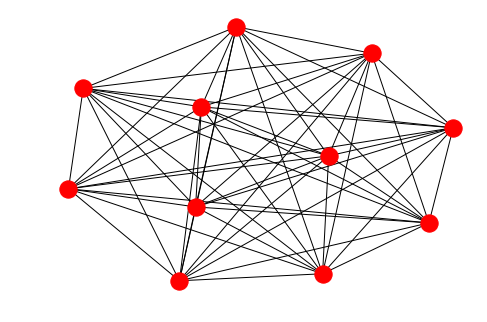

In [11]:
nx.draw(Z)

In [15]:
#Fits a power-law function to the degree distribution of the network, then graphs the function
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

ydata=cnt
xdata=deg 

def func_powerlaw(x, m, c):
    return  x**m * c

target_func = func_powerlaw
popt, pcov = curve_fit(target_func, xdata, ydata,maxfev=2000)
print(popt)

plt.figure(figsize=(10, 5))
plt.plot(xdata, target_func(xdata, *popt), '--')
plt.plot(xdata, ydata, 'ro')

plt.xlim(0,30)
plt.ylim(0,1000)
plt.show()

In [16]:
#Calculates the fit of the power-law regression by r-squared.
def get_rsq(f, y, popt):

    ss_res = np.dot((y - f(xdata, *popt)),(y - f(xdata, *popt)))
    ymean = np.mean(y)
    ss_tot = np.dot((y-ymean),(y-ymean))
    return (1-ss_res/ss_tot)

get_rsq(f,y,popt)

In [128]:
#Different methods of computing the centrality of the nodes in the network, sorted descending.
from operator import itemgetter
sorted(nx.eigenvector_centrality(G).items(), key=itemgetter(1), reverse= True)
sorted(nx.degree_centrality(G).items(), key=itemgetter(1), reverse= True)
sorted(nx.closeness_centrality(G).items(), key=itemgetter(1), reverse= True)

[(User(_api=<tweepy.api.API object at 0x000001F027285F28>, _json={'id': 338141312, 'id_str': '338141312', 'name': 'moogz (ft. pitbull)', 'screen_name': '_moogz', 'location': '', 'profile_location': None, 'description': 'ask me about my buffalo chicken dip', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 390, 'friends_count': 332, 'listed_count': 0, 'created_at': 'Tue Jul 19 04:09:41 +0000 2011', 'favourites_count': 11947, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 3941, 'lang': 'en', 'status': {'created_at': 'Fri Jul 06 19:42:42 +0000 2018', 'id': 1015320151871442946, 'id_str': '1015320151871442946', 'text': '@narenakurati Hello Naren Akurati', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'narenakurati', 'name': 'Naren Akurati', 'id': 177770848, 'id_str': '177770848', 'indices': [0, 13]}], 'urls': []}, 'source': '<a href="http://twit